### ARIMA / SARIMAX

In [232]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sms
import pandas as pd

%matplotlib inline

df_airline = pd.read_csv('airline_passengers.csv')
df_airline.head()

,Month,Thousands of Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [233]:
df_airline.isnull().sum()

Month                      0
Thousands of Passengers    1
dtype: int64

In [234]:
df_airline.tail()

,Month,Thousands of Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [235]:
df_airline.dropna(inplace=True, axis=0)

In [236]:
df_airline.isnull().sum()

Month                      0
Thousands of Passengers    0
dtype: int64

In [237]:
df_airline.info()


<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    144 non-null    object 
 1   Thousands of Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


In [238]:
df_airline["Month"] = pd.to_datetime(df_airline["Month"])

In [239]:
df_airline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    144 non-null    datetime64[ns]
 1   Thousands of Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [240]:
df_airline.set_index("Month", inplace=True)

In [241]:
df_airline.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


<Axes: xlabel='Month'>

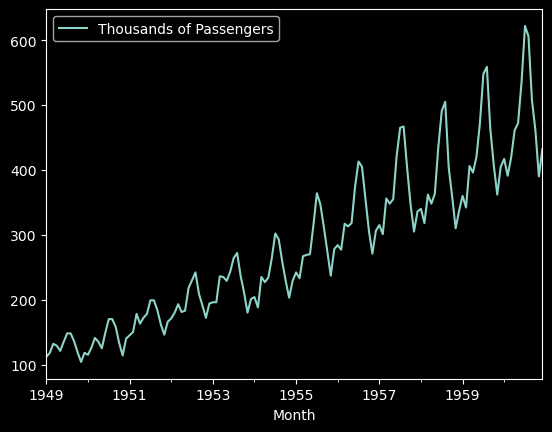

In [242]:
df_airline.plot()

In [243]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    
    result = adfuller(series)
    
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [244]:
adf_test(df_airline['Thousands of Passengers'])

ADF Statistics: 0.8153688792060597
p- value: 0.9918802434376411
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### Differencing to make data stationary

In [245]:
df_airline['Passengers First Difference'] = df_airline['Thousands of Passengers'] - df_airline['Thousands of Passengers'].shift(1)

In [246]:
df_airline.head()

,Thousands of Passengers,Passengers First Difference
Month,,
1949-01-01,112.0,NaN
1949-02-01,118.0,6.0
1949-03-01,132.0,14.0
1949-04-01,129.0,-3.0
1949-05-01,121.0,-8.0


In [247]:
adf_test(df_airline['Passengers First Difference'].dropna())

ADF Statistics: -2.829266824169992
p- value: 0.0542132902838265
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [248]:
## Use Techniques Differencing
df_airline['Passengers Second Difference'] = df_airline['Passengers First Difference'] - df_airline['Passengers First Difference'].shift(1)

In [249]:
adf_test(df_airline['Passengers Second Difference'].dropna())

ADF Statistics: -16.384231542468527
p- value: 2.732891850014085e-29
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary



### For SARIMAX we give 12 months difference i.e sesonal difference

In [250]:
df_airline['Passengers 12 Difference'] = df_airline['Thousands of Passengers']-df_airline['Thousands of Passengers'].shift(12)

adf_test(df_airline['Passengers 12 Difference'].dropna())

ADF Statistics: -3.3830207264924805
p- value: 0.011551493085514982
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


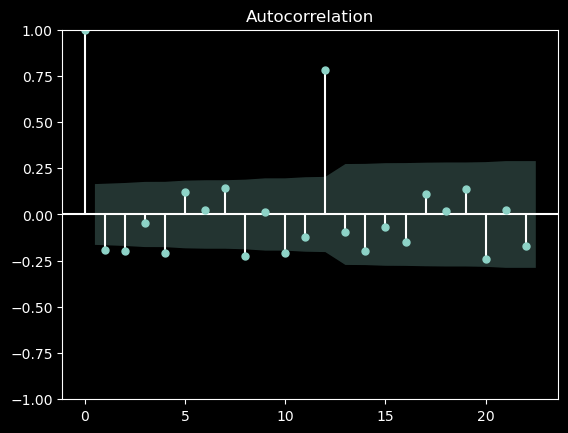

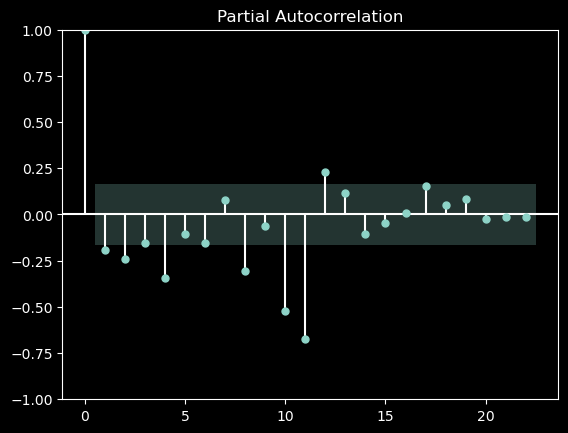

In [251]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

acf = plot_acf(df_airline["Passengers Second Difference"].dropna())
result = plot_pacf(df_airline["Passengers Second Difference"].dropna())

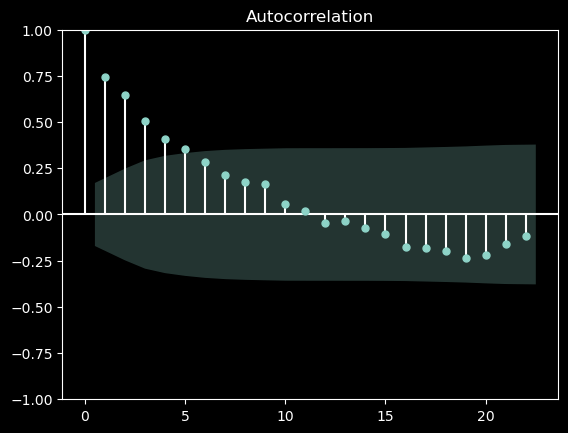

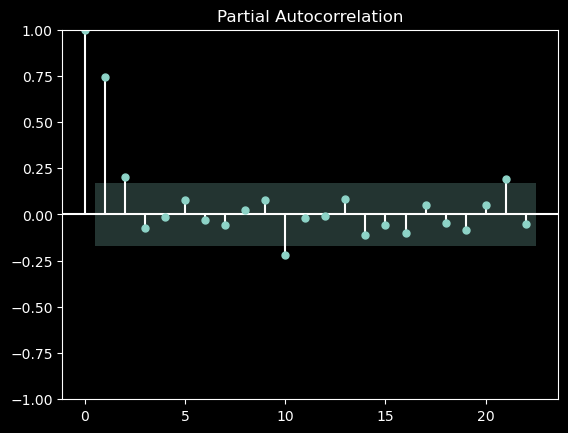

In [252]:
acf12 = plot_acf(df_airline["Passengers 12 Difference"].dropna())
pacf12 = plot_pacf(df_airline["Passengers 12 Difference"].dropna())

In [253]:
df_airline.head(3)

,Thousands of Passengers,Passengers First Difference,Passengers Second Difference,Passengers 12 Difference
Month,,,,
1949-01-01,112.0,NaN,NaN,NaN
1949-02-01,118.0,6.0,NaN,NaN
1949-03-01,132.0,14.0,8.0,NaN


### Split train and test data

In [254]:
from datetime import datetime,timedelta
train_dataset_end = datetime(1955,12,1)
test_dataset_end = datetime(1960,12,1)

train_data = df_airline[:train_dataset_end]
test_data = df_airline[train_dataset_end + timedelta(days=1):test_dataset_end]

In [255]:
"""Prediction"""
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1] 

## Create a ARIMA model

In [256]:
from statsmodels.tsa.arima.model import ARIMA

model_ARIMA = ARIMA(train_data['Thousands of Passengers'], order=(10,2,5))

c:\Users\shrey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\shrey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\shrey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [257]:
model_Arima_fit = model_ARIMA.fit()

c:\Users\shrey\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\shrey\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\shrey\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [258]:
model_Arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Thousands of Passengers   No. Observations:                   84
Model:                     ARIMA(10, 2, 5)   Log Likelihood                -310.527
Date:                     Mon, 08 Jan 2024   AIC                            653.055
Time:                             15:41:54   BIC                            691.562
Sample:                         01-01-1949   HQIC                           668.515
                              - 12-01-1955                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0679      0.115      0.589      0.556      -0.158       0.294
ar.L2         -0.9560      0.094    -10.195      0.000      -1.140      -0.772
ar.L3         -0.0274      0.137     -0.199      0.842      -0.297       0.242
ar.L4         -0.7939      0.112     -7.095      0.000      -1.013      -0.575
ar.L5         -0.1934      0.141     -1.373      0.170      -0.469       0.083
ar.L6         -0.6349      0.115     -5.526      0.000      -0.860      -0.410
ar.L7         -0.2342      0.126     -1.861      0.063      -0.481       0.012
ar.L8         -0.7234      0.124     -5.840      0.000      -0.966      -0.481
ar.L9         -0.1409      0.091     -1.551      0.121      -0.319       0.037
ar.L10        -0.7985      0.075    -10.621      0.000      -0.946      -0.651
ma.L1         -1.2323      0.180     -6.837      0.000      -1.586      -0.879
ma.L2          1.1008      0.256      4.304      0.000       0.600       1.602
ma.L3         -1.1195      0.241     -4.650      0.000      -1.591      -0.648
ma.L4          0.7954      0.304      2.618      0.009       0.200       1.391
ma.L5         -0.3658      0.198     -1.845      0.065      -0.754       0.023
sigma2        95.0141     21.305      4.460      0.000      53.258     136.770
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                 1.33
Prob(Q):                              0.48   Prob(JB):                         0.51
Heteroskedasticity (H):               1.88   Skew:                             0.30
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [259]:
test_data.head()

,Thousands of Passengers,Passengers First Difference,Passengers Second Difference,Passengers 12 Difference
Month,,,,
1956-01-01,284.0,6.0,-35.0,42.0
1956-02-01,277.0,-7.0,-13.0,44.0
1956-03-01,317.0,40.0,47.0,50.0
1956-04-01,313.0,-4.0,-44.0,44.0
1956-05-01,318.0,5.0,9.0,48.0


In [260]:
##prediction
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

1956-01-01 00:00:00
1960-12-01 00:00:00


In [261]:
pred = model_Arima_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data['Thousands of Passengers'] - pred

In [262]:
residuals, pred

(Month
 1956-01-01    -2.031706
 1956-02-01    -2.385500
 1956-03-01    17.306823
 1956-04-01     6.765984
 1956-05-01     5.461937
 1956-06-01    17.070472
 1956-07-01    10.310049
 1956-08-01    24.277519
 1956-09-01     1.956229
 1956-10-01    -8.906939
 1956-11-01   -16.190267
 1956-12-01   -11.594309
 1957-01-01   -15.701741
 1957-02-01   -21.345907
 1957-03-01    21.452666
 1957-04-01     0.654609
 1957-05-01     2.980601
 1957-06-01    23.496653
 1957-07-01    25.724715
 1957-08-01    49.022790
 1957-09-01    12.905295
 1957-10-01   -11.070734
 1957-11-01   -30.098505
 1957-12-01   -22.382012
 1958-01-01   -35.016522
 1958-02-01   -45.827330
 1958-03-01    -9.857096
 1958-04-01   -38.834394
 1958-05-01   -30.402989
 1958-06-01    -3.678115
 1958-07-01    15.003161
 1958-08-01    48.982100
 1958-09-01   -24.609052
 1958-10-01   -42.807721
 1958-11-01   -71.587421
 1958-12-01   -63.341260
 1959-01-01   -58.158801
 1959-02-01   -63.305389
 1959-03-01    -4.007624
 1959-04-01   -30.

<Axes: ylabel='Density'>

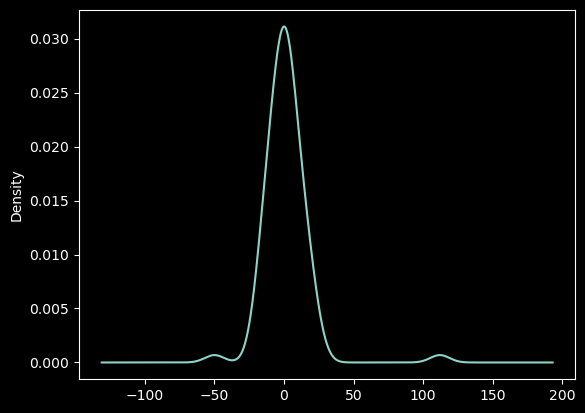

In [263]:
model_Arima_fit.resid.plot(kind='kde')

C:\Users\shrey\AppData\Local\Temp\ipykernel_11476\4100194304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_ARIMA'] = pred


<Axes: xlabel='Month'>

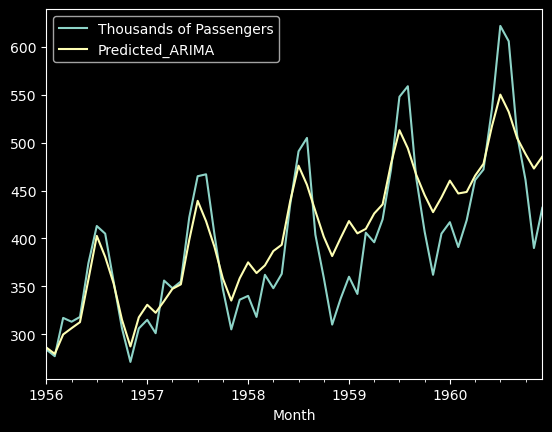

In [264]:
test_data['Predicted_ARIMA'] = pred

test_data[['Thousands of Passengers','Predicted_ARIMA']].plot()

## Create a SARIMAX model

In [265]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_SARIMA = SARIMAX(train_data['Thousands of Passengers'],order=(3,0,5),seasonal_order=(0,1,0,12))
model_SARIMA_fit = model_SARIMA.fit()
model_SARIMA_fit.summary()

c:\Users\shrey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\shrey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\shrey\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             Thousands of Passengers   No. Observations:                   84
Model:             SARIMAX(3, 0, 5)x(0, 1, [], 12)   Log Likelihood                -265.240
Date:                             Mon, 08 Jan 2024   AIC                            548.481
Time:                                     15:41:55   BIC                            568.971
Sample:                                 01-01-1949   HQIC                           556.638
                                      - 12-01-1955                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5982      0.937      0.638      0.523      -1.239       2.435
ar.L2          0.8311      0.232      3.582      0.000       0.376       1.286
ar.L3         -0.4523      0.894     -0.506      0.613      -2.204       1.299
ma.L1          0.1839      1.164      0.158      0.874      -2.097       2.465
ma.L2         -0.5340      1.262     -0.423      0.672      -3.007       1.939
ma.L3         -0.0987      0.384     -0.257      0.797      -0.851       0.654
ma.L4         -0.1273      0.337     -0.377      0.706      -0.788       0.534
ma.L5          0.2471      0.357      0.693      0.488      -0.452       0.946
sigma2        87.7334     81.111      1.082      0.279     -71.240     246.707
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.68
Prob(Q):                              0.88   Prob(JB):                         0.26
Heteroskedasticity (H):               2.05   Skew:                             0.46
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [266]:
test_data.tail()

,Thousands of Passengers,Passengers First Difference,Passengers Second Difference,Passengers 12 Difference,Predicted_ARIMA
Month,,,,,
1960-08-01,606.0,-16.0,-103.0,47.0,532.213419
1960-09-01,508.0,-98.0,-82.0,45.0,504.922841
1960-10-01,461.0,-47.0,51.0,54.0,488.194429
1960-11-01,390.0,-71.0,-24.0,28.0,473.021693
1960-12-01,432.0,42.0,113.0,27.0,485.544601


1956-01-01 00:00:00
1960-12-01 00:00:00


<Axes: xlabel='Month'>

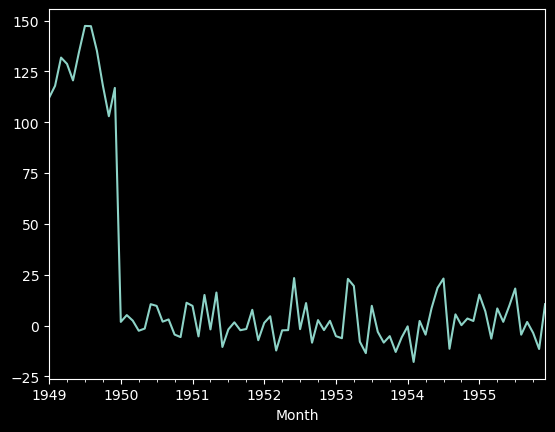

In [267]:
##prediction
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

pred_Sarima = model_SARIMA_fit.predict(start=datetime(1956,6,6),end=datetime(1960,12,1))
residuals = test_data['Thousands of Passengers'] - pred_Sarima

model_SARIMA_fit.resid.plot()

<Axes: ylabel='Density'>

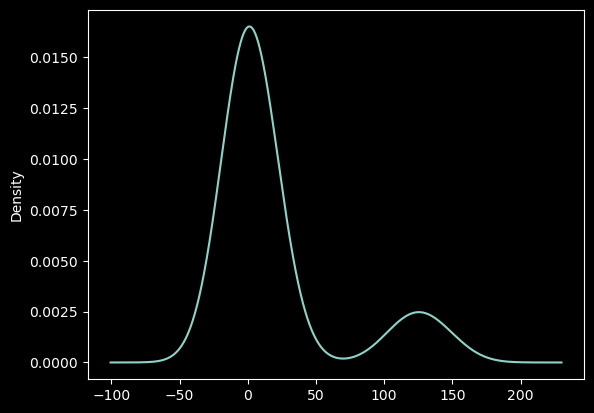

In [268]:
model_SARIMA_fit.resid.plot(kind='kde')

In [269]:
test_data['Predicted_SARIMAX'] = pred_Sarima

C:\Users\shrey\AppData\Local\Temp\ipykernel_11476\3442192086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_SARIMAX'] = pred_Sarima


<Axes: xlabel='Month'>

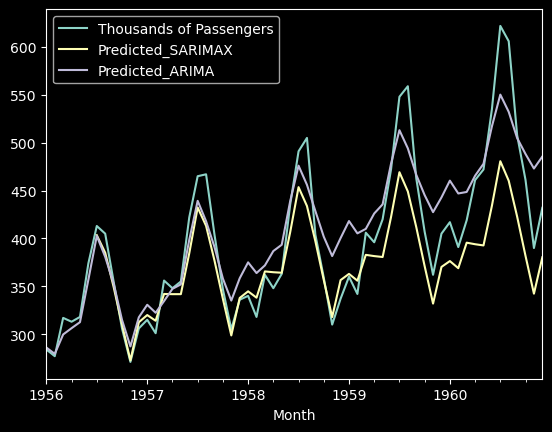

In [270]:
test_data[['Thousands of Passengers','Predicted_SARIMAX','Predicted_ARIMA']].plot()